In [1]:
import pandas as pd
import numpy as np
import os
import env
from env import host, user, pwd
from pydataset import data
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import reg_wrangle

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

In [2]:
swiss = data('swiss')

In [3]:
swiss.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [4]:
swiss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [5]:
# return the variables.   must prefix it with my wrangle file
train, validate, test = reg_wrangle.split_data(swiss)

In [6]:
train.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Rolle,60.5,60.8,16,10,7.72,16.3
Lavaux,65.1,73.0,19,9,2.84,20.0
Nyone,56.6,50.9,22,12,15.14,16.7
Conthey,75.5,85.9,3,2,99.71,15.1
Yverdon,65.4,49.5,15,8,6.10,22.5


In [7]:
predictions = pd.DataFrame({
    'actual': validate.Fertility
})

In [8]:
predictions.head()

,actual
Moudon,65.0
Echallens,68.3
Moutier,85.8
Morges,65.5
Sierre,92.2


In [9]:
from sklearn.linear_model import LinearRegression

# X must be 2-d
X_train = train[['Education']]
# y can be 1-d
y_train = train.Fertility

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['Education']]
predictions['simple_lm'] = lm.predict(X_validate)

In [10]:
predictions.head()

,actual,simple_lm
Moudon,65.0,74.126028
Echallens,68.3,74.538453
Moutier,85.8,72.476329
Morges,65.5,71.239054
Sierre,92.2,74.126028


In [11]:
lm.coef_, lm.intercept_

(array([-0.41242488]), 75.36330289549676)

In [12]:
print('Fertility = {:.3f} * Education + {:.3f}'.format(lm.coef_[0], lm.intercept_))

Fertility = -0.412 * Education + 75.363


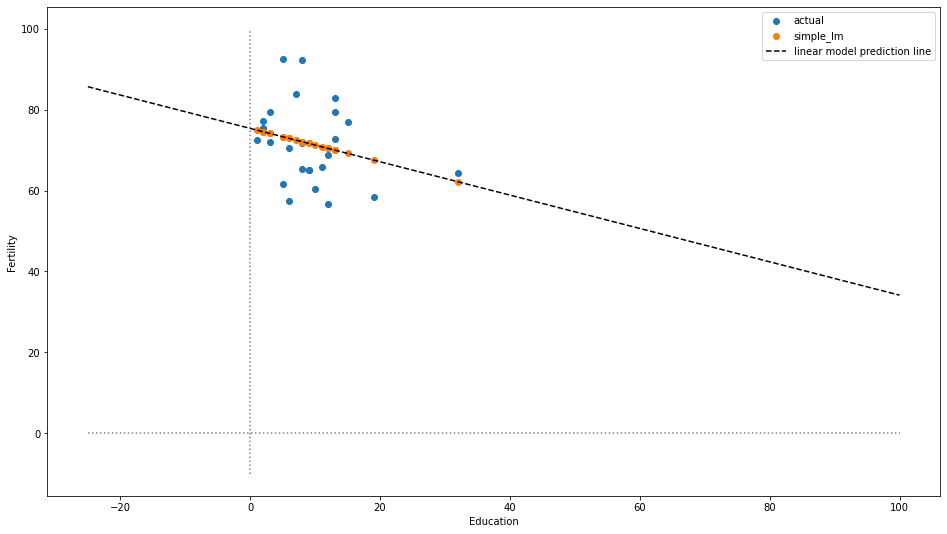

In [13]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.Education, train.Fertility, label='actual')
plt.scatter(train.Education, lm.predict(train[['Education']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Education')
plt.ylabel('Fertility')
plt.legend()

In [14]:
print(f'For every 1 point increase in Education, we predict a {lm.coef_[0]:.2f} point increase in Fertility')

For every 1 point increase in Education, we predict a -0.41 point increase in Fertility


In [15]:
Education = np.arange(90, 96)
Fertility = lm.predict(Education.reshape(-1, 1))
pd.DataFrame(dict(Education=Education, predicted_Fertility=Fertility))

,Education,predicted_Fertility
0,90,38.245064
1,91,37.832639
2,92,37.420214
3,93,37.007789
4,94,36.595364
5,95,36.182939


In [16]:
X_train = train.drop(columns='Fertility')
y_train = train.Fertility
X_validate = validate.drop(columns='Fertility')

lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

selected top 2 features: Index(['Examination', 'Infant.Mortality'], dtype='object')


In [17]:
X_train.shape

(25, 5)

In [18]:
X_train_rfe.shape

(25, 2)

In [19]:
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

,actual,simple_lm,multiple_rfe
Moudon,65.0,74.126028,79.180470
Echallens,68.3,74.538453,72.719716
Moutier,85.8,72.476329,75.987317
Morges,65.5,71.239054,61.500793
Sierre,92.2,74.126028,74.584142


In [20]:
X_train.columns[rfe.support_]

Index(['Examination', 'Infant.Mortality'], dtype='object')

In [21]:
lm.coef_, lm.intercept_

(array([-0.90146286,  2.37908502]), 38.50944506277681)

In [22]:
from sklearn.preprocessing import PolynomialFeatures

X_train = train[['Education', 'Examination', 'Catholic']]
X_validate = validate[['Education', 'Examination', 'Catholic']]
y_train = train.Fertility
y_validate = validate.Fertility

# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
X_train_poly.head()

,Education,Examination,Catholic,Education^2,Education Examination,Education Catholic,Examination^2,Examination Catholic,Catholic^2
Rolle,10.0,16.0,7.72,100.0,160.0,77.20,256.0,123.52,59.5984
Lavaux,9.0,19.0,2.84,81.0,171.0,25.56,361.0,53.96,8.0656
Nyone,12.0,22.0,15.14,144.0,264.0,181.68,484.0,333.08,229.2196
Conthey,2.0,3.0,99.71,4.0,6.0,199.42,9.0,299.13,9942.0841
Yverdon,8.0,15.0,6.10,64.0,120.0,48.80,225.0,91.50,37.2100


In [23]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)

In [24]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2
Moudon,65.0,74.126028,79.180470,67.091556
Echallens,68.3,74.538453,72.719716,75.626180
Moutier,85.8,72.476329,75.987317,76.633342
Morges,65.5,71.239054,61.500793,61.168322
Sierre,92.2,74.126028,74.584142,77.429711


In [25]:
feature_names = poly.get_feature_names(X_train.columns)
pd.Series(lm.coef_, index=feature_names).sort_values()

Examination             -2.187215
Education Examination   -0.170863
Education Catholic      -0.019207
Catholic^2              -0.001511
Examination Catholic     0.024923
Examination^2            0.070350
Catholic                 0.087638
Education^2              0.098857
Education                1.733300
dtype: float64

In [26]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train.columns)).sort_values()

Examination             -0.934445
Catholic                -0.022024
Education Catholic      -0.008171
Education Examination    0.004691
Examination Catholic     0.015882
Education                0.229264
dtype: float64

In [27]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction
Moudon,65.0,74.126028,79.180470,67.091556,67.767716
Echallens,68.3,74.538453,72.719716,75.626180,68.967473
Moutier,85.8,72.476329,75.987317,76.633342,73.716511
Morges,65.5,71.239054,61.500793,61.168322,63.222075
Sierre,92.2,74.126028,74.584142,77.429711,77.207215


In [28]:
from sklearn.linear_model import LassoLars

In [29]:
# create the model object
lars = LassoLars(alpha=0)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

In [30]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

Examination   -0.413753
Catholic       0.110860
Education      0.161405
dtype: float64

In [31]:
# create the model object
lars = LassoLars(alpha=0.5)

# fit the model to our training data= 
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

In [32]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

Examination   -0.078191
Education      0.000000
Catholic       0.081678
dtype: float64

In [33]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

In [34]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

Education      0.000000
Examination    0.000000
Catholic       0.032551
dtype: float64

In [35]:
# create the model object
lars_high_alpha = LassoLars(alpha=2)

# fit the model to our training data
lars_high_alpha.fit(X_train, y_train)

# predict validate
X_validate_pred_lars_high_alpha = lars.predict(X_validate)

In [36]:
pd.Series(lars_high_alpha.coef_, index=X_train.columns).sort_values()

Education      0.0
Examination    0.0
Catholic       0.0
dtype: float64

In [37]:
from sklearn.linear_model import TweedieRegressor

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

In [38]:
pd.Series(glm.coef_, index=X_train.columns).sort_values()

Examination   -0.005899
Catholic       0.001509
Education      0.002371
dtype: float64

In [39]:
glm.intercept_

4.271882446079915

In [40]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm
Moudon,65.0,74.126028,79.180470,67.091556,67.767716,70.270910,66.901698
Echallens,68.3,74.538453,72.719716,75.626180,68.967473,70.911508,67.151619
Moutier,85.8,72.476329,75.987317,76.633342,73.716511,71.223018,71.424742
Morges,65.5,71.239054,61.500793,61.168322,63.222075,70.294021,64.955109
Sierre,92.2,74.126028,74.584142,77.429711,77.207215,73.361275,82.383169


In [41]:
# add a baseline model
predictions['baseline'] = train.Fertility.mean()

In [42]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
Moudon,65.0,74.126028,79.180470,67.091556,67.767716,70.270910,66.901698,71.536
Echallens,68.3,74.538453,72.719716,75.626180,68.967473,70.911508,67.151619,71.536
Moutier,85.8,72.476329,75.987317,76.633342,73.716511,71.223018,71.424742,71.536
Morges,65.5,71.239054,61.500793,61.168322,63.222075,70.294021,64.955109,71.536
Sierre,92.2,74.126028,74.584142,77.429711,77.207215,73.361275,82.383169,71.536


In [43]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

actual                           0.000000
simple_lm                      135.907718
multiple_rfe                   152.658638
polynomial only interaction    205.419260
glm                            212.148392
lasso_lars                     212.689055
baseline                       218.478263
polynomial degree 2            691.512638
dtype: float64

In [ ]:
# re-create our polynomial model
X_train = train[['exam1', 'exam2', 'exam3']]
y_train = train.final_grade

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)

lm = LinearRegression()
lm.fit(X_train_poly, y_train)